In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from backend.algorithms.normalization import normalizar_texto
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'backend'

In [30]:
df= pd.read_csv("data/patrones.csv")


In [31]:
# Para limpiar los patrones antes de entrenar al modelo
df['patron_limpio'] = df['patron'].apply(normalizar_texto)

In [32]:
x = df['patron_limpio']
y = df['categoria']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [34]:
stopwords_es = ['el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'de', 'del', 'y', 'o', 'que', 'en', 'a']

In [35]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        preprocessor=normalizar_texto,
        stop_words=stopwords_es, 
        max_features=100,
        ngram_range=(1, 2)       
    )),
    ("clf", LogisticRegression(max_iter=1000))
])

In [36]:
pipeline.fit(x_train, y_train)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function nor...001EBBBA95120>
,tokenizer,None


In [37]:
pipeline.predict(["hola buen día, ¿cómo estás?"])

array(['Riesgo legal'], dtype=object)

In [38]:
pipeline.score(x_test, y_test)

0.65

In [39]:
df['categoria'].value_counts()

categoria
Riesgo legal       100
Reclamo crítico    100
Reclamo            100
Queja leve         100
Name: count, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

print("Train score:", pipeline.score(X_train, y_train))
print("Test score:", pipeline.score(X_test, y_test))

Train score: 0.784375
Test score: 0.65


In [41]:
pipeline.predict(["el cliente menciona posibles acciones legales si no resolvemos el caso"])

array(['Riesgo legal'], dtype=object)

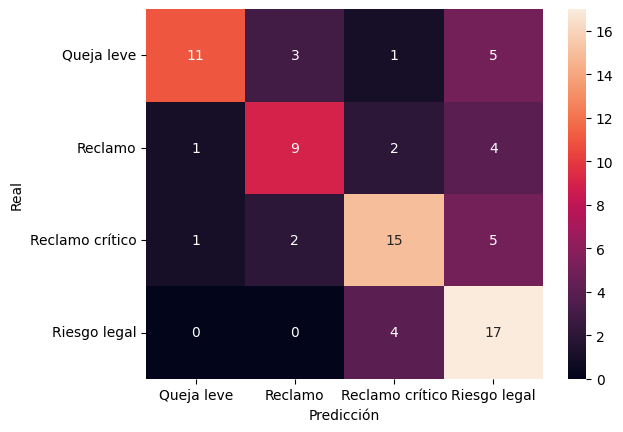

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = pipeline.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, annot=True, fmt='d', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
# Lista de frases nuevas (nunca antes vistas por el modelo)
frases_test = [
    "Mañana mismo presento una demanda con mi abogado",           # Debería ser: Riesgo legal
    "No funciona la app y nadie me da una respuesta",             # Debería ser: Reclamo
    "¡Es el peor servicio del mundo, quiero hablar con un jefe!", # Debería ser: Reclamo crítico
    "El repartidor tardó un poquito más de lo normal",            # Debería ser: Queja leve
    "Me están estafando, esto es un fraude legal"                 # Debería ser: Riesgo legal
]

print("\n--- PRUEBA DE FUEGO ---")
for frase in frases_test:
    prediccion = pipeline.predict([frase])[0]
    probabilidades = pipeline.predict_proba([frase])
    confianza = np.max(probabilidades) * 100
    
    print(f"Frase: '{frase}'")
    print(f"Predicción: {prediccion} ({confianza:.2f}% de confianza)")
    print("-" * 30)


--- PRUEBA DE FUEGO ---
Frase: 'Mañana mismo presento una demanda con mi abogado'
Predicción: Riesgo legal (44.31% de confianza)
------------------------------
Frase: 'No funciona la app y nadie me da una respuesta'
Predicción: Reclamo (56.88% de confianza)
------------------------------
Frase: '¡Es el peor servicio del mundo, quiero hablar con un jefe!'
Predicción: Reclamo crítico (55.53% de confianza)
------------------------------
Frase: 'El repartidor tardó un poquito más de lo normal'
Predicción: Queja leve (34.52% de confianza)
------------------------------
Frase: 'Me están estafando, esto es un fraude legal'
Predicción: Riesgo legal (62.28% de confianza)
------------------------------


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipeline.predict(X_test)))

                 precision    recall  f1-score   support

     Queja leve       0.85      0.55      0.67        20
        Reclamo       0.64      0.56      0.60        16
Reclamo crítico       0.68      0.65      0.67        23
   Riesgo legal       0.55      0.81      0.65        21

       accuracy                           0.65        80
      macro avg       0.68      0.64      0.65        80
   weighted avg       0.68      0.65      0.65        80



# Detección de patrones para clasificiación

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = pipeline.named_steps["tfidf"]

patrones_vec = vectorizer.transform(x)

In [46]:
def es_candidata_por_similitud(frase, threshold=0.30):
    frase_vec = vectorizer.transform([frase])
    similitudes = cosine_similarity(frase_vec, patrones_vec)
    max_similitud = similitudes.max()
    return max_similitud > threshold

In [47]:
import re

def segmentar_texto(texto):
    frases = re.split(r'[.!?]\s+', texto)
    return [f.strip() for f in frases if len(f.strip()) > 0]

In [48]:
def analizar_texto(texto, modelo):
    frases = segmentar_texto(texto)
    resultados = []

    for frase in frases:
        if es_candidata_por_similitud(frase, threshold=0.30):
            categoria = modelo.predict([frase])[0]
            prob = max(modelo.predict_proba([frase])[0])

            if prob > 0.60:
                resultados.append((frase, categoria, prob))

    return resultados

In [49]:
texto_normal = """
Hola buenos días.
Adjunto el documento solicitado.
Quedo atento a su respuesta.
Muchas gracias.
"""

In [50]:
texto_reclamo = """
Buenas tardes.
Hace semanas que no recibo respuesta.
Estoy bastante disconforme con el servicio.
Agradecería una solución.
"""

In [61]:
texto_legal = """
Buenas tardes.
Si no obtengo respuesta iniciaré las acciones correspondientes.
Voy a demandar y tomar acciones legales.
"""

In [62]:
print(analizar_texto(texto_normal, pipeline))
print(analizar_texto(texto_reclamo, pipeline))
print(analizar_texto(texto_legal, pipeline))

[]
[('Estoy bastante disconforme con el servicio', 'Reclamo crítico', np.float64(0.7032589849452218))]
[('Voy a demandar y tomar acciones legales', 'Riesgo legal', np.float64(0.7008947516634737))]


In [63]:
texto_mixto = """
Hola equipo.
Gracias por la reunión.
Hace meses que no recibo solución.
Esto constituye un incumplimiento grave del contrato.
Si no se resuelve iniciaré acciones legales.
Saludos.
"""
print(analizar_texto(texto_mixto, pipeline))

[('Esto constituye un incumplimiento grave del contrato', 'Riesgo legal', np.float64(0.8128177349946012))]
